In [1]:
import io
import sys
import pandas as pd
import numpy as np
from Pipeline import DPA
import os
sys.path.append('../')
from simulate_frbs import *
from plotting import *
import scipy.signal
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [3]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

## DPA on dynamic spectra

In [14]:
directories = [
    "correct_noise_simple_broad",
    "correct_noise_simple_narrow",
    "correct_noise_scattered",
    "correct_noise_complex",
    "correct_noise_drifting"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # data_per_directory.append(sgolay2d( np.load(os.path.join(data_dir, filename)), window_size=99, order=4))
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            mean = np.mean(dynamic_spectra_w_pulse) 
            std = np.std(dynamic_spectra_w_pulse)
            threshold = mean + 1 * std
            
            # plot_dynamic_spectra(dynamic_spectra_w_pulse)
            # Apply thresholding
            dynamic_spectra_w_pulse[dynamic_spectra_w_pulse < threshold] = 0
            # scaler = StandardScaler()
            # dynamic_spectra_w_pulse = scaler.fit_transform(dynamic_spectra_w_pulse)
            # plot_dynamic_spectra(dynamic_spectra_w_pulse, 'Dynamic Spectra Clipped')

            # sys.exit()

            data_per_directory.append(dynamic_spectra_w_pulse)

            # plot_dynamic_spectra(np.load(os.path.join(data_dir, filename)))
            # print('next')
            # plot_dynamic_spectra(sgolay2d( np.load(os.path.join(data_dir, filename)), window_size=99, order=4))

    data_per_directory = np.array(data_per_directory).reshape(-1, 1024 * 512)[:100]
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, 1024 * 512)

print(combined_data_2d.shape)


(500, 524288)


In [25]:
est = DPA.DensityPeakAdvanced(Z=1.5)

In [26]:
est.fit(combined_data_2d)

DensityPeakAdvanced(Z=1.5)

In [27]:
est.topography_

[[0, 1, 21.785371170177186, 0.7264831572567789],
 [0, 2, 22.522052192368804, 0.6831300510639732],
 [0, 3, 18.422218905261502, 0.7791937224739796],
 [0, 4, 19.20422210737256, 0.4645314560761311],
 [0, 5, 19.74829935603337, 0.7791937224739796],
 [0, 6, 0.0, 0.0],
 [0, 7, 22.27896192321559, 0.6466697906828632],
 [1, 2, 0.0, 0.0],
 [1, 3, 0.0, 0.0],
 [1, 4, 0.0, 0.0],
 [1, 5, 0.0, 0.0],
 [1, 6, 0.0, 0.0],
 [1, 7, 17.03089048252987, 0.6831300510639732],
 [2, 3, 0.0, 0.0],
 [2, 4, 0.0, 0.0],
 [2, 5, 0.0, 0.0],
 [2, 6, 0.0, 0.0],
 [2, 7, 20.06706849017077, 0.6831300510639732],
 [3, 4, 0.0, 0.0],
 [3, 5, 0.0, 0.0],
 [3, 6, 0.0, 0.0],
 [3, 7, 0.0, 0.0],
 [4, 5, 0.0, 0.0],
 [4, 6, 0.0, 0.0],
 [4, 7, 0.0, 0.0],
 [5, 6, 0.0, 0.0],
 [5, 7, 12.414997180050563, 1.0488088481701516],
 [6, 7, 22.283320374407168, 0.5883484054145521]]

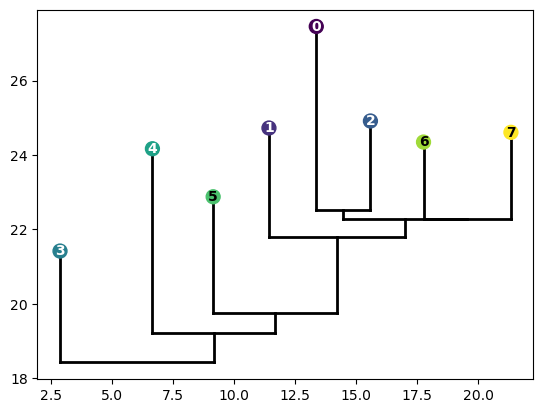

In [28]:
est.get_dendrogram()

In [8]:
# est.labels_
# est.halos_
est.centers_

[59, 80, 177, 215, 220, 468, 304]

308


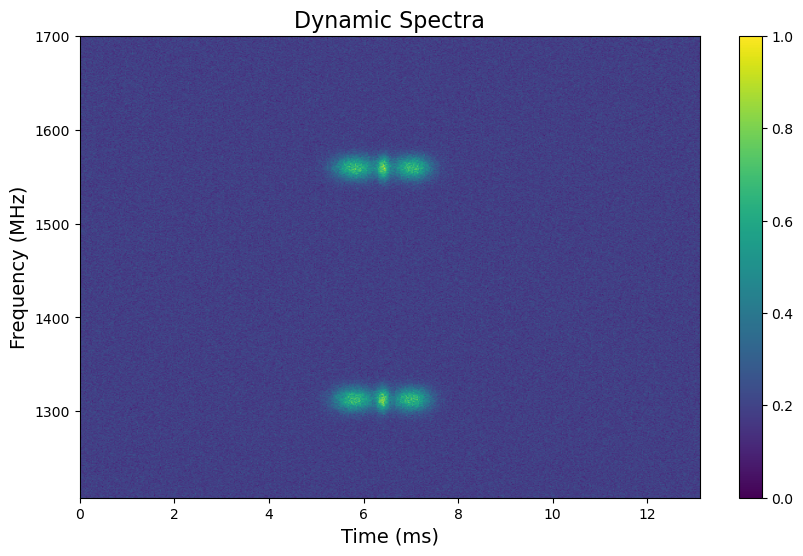

In [65]:
label_to_find = 2

# Find indices of bursts with the specified label
burst_indices = np.where(est.labels_ == label_to_find)[0]

# Plot the dynamic spectrum for each burst with the specified label
for idx in burst_indices:
    print(idx)
    dynamic_spectrum = combined_data_2d[idx].reshape(512, 1024)  # Adjust the shape based on your data dimensions
    plot_dynamic_spectra(dynamic_spectrum)

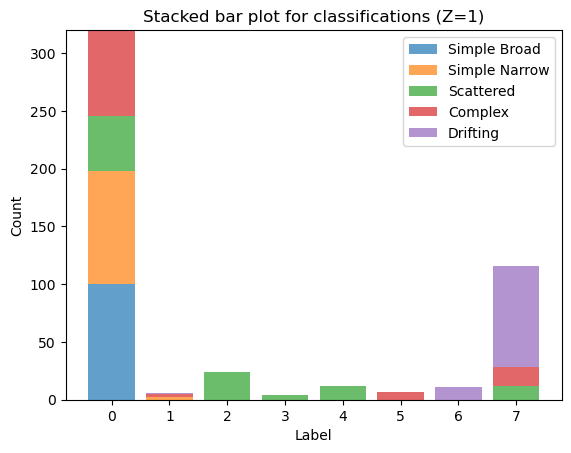

In [29]:
labels = [label if label >= 0 else 10 for label in est.labels_]


# Number of classes (assuming each class has 100 labels)
num_classes = int(len(labels) / 100)

# Reshape the labels into a 2D array where each row corresponds to a class
labels_2d = np.array(labels).reshape(num_classes, -1)

# Count the occurrences of each label in each class
class_counts = [np.bincount(class_labels, minlength=np.max(labels) + 1) for class_labels in labels_2d]

# Plot a stacked bar plot for each class
bottom = np.zeros(np.max(labels) + 1)
for i, counts in enumerate(class_counts):
    plt.bar(range(len(counts)), counts, bottom=bottom, alpha=0.7, label=f'Class {i}')
    bottom += counts

class_names = ["Simple Broad", "Simple Narrow", "Scattered", "Complex", "Drifting"]

plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(class_names)
plt.title('Stacked bar plot for classifications (Z=1)')
plt.show()



## DPA on lightcurves

In [33]:
directories = [
    "simulated_simple_broad_bursts_v4",
    "simulated_simple_narrow_bursts_v4",
    "simulated_scattered_bursts_v4",
    "simulated_complex_bursts_v4",
    "simulated_drifting_bursts_v4"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            dynamic_spectra = (np.load(os.path.join(data_dir, filename)))
            data_per_directory.append(normalize(np.sum(dynamic_spectra, axis=1)))

    data_per_directory = np.array(data_per_directory).reshape(-1, 1024)[:100]
    print(np.max(data_per_directory))
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, 1024)

print(combined_data_2d.shape)

1.0
1.0
1.0
1.0
1.0
(500, 1024)


In [37]:
est = DPA.DensityPeakAdvanced(Z=0.5)
est.fit(combined_data_2d)

DensityPeakAdvanced(Z=0.5)

In [38]:
est.topography_

[[0, 1, 7.142156917907826, 0.30318178032195786],
 [0, 2, 9.024764229168056, 0.2901442287369986],
 [1, 2, 0.0, 0.0]]

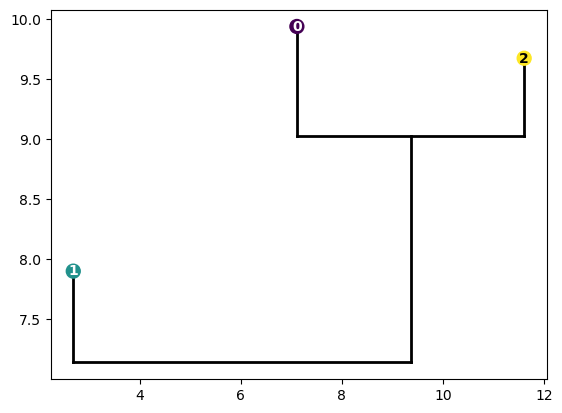

In [39]:
est.get_dendrogram()